In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import entropy
import statistics
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Part 1

In [2]:
#I use random forest for the base learner. Then I calculate the entropy of each unlabeled sample and ask oracle 
#for the one with the most uncertainty.
#read in the csv files
own = pd.read_csv('Our_drug_simulation_dataset.csv')
own = own.drop(["Unnamed: 0"], axis = 1)
data = own.values
data.shape

(20736, 5)

In [3]:
test_idx = np.random.choice(data.shape[0], 54, replace = False)
test_set = data[test_idx]
mask = np.full(len(data), True)
mask[test_idx] = False
train_set = data[mask]
print(test_set.shape)
print(train_set.shape)

(54, 5)
(20682, 5)


In [11]:

RF = RandomForestRegressor()
batch_size = 3
np.random.seed(35)
seed_pool = np.random.choice(10000, 10, replace = False)

In [14]:
def initial_sample(seed_idx, seed_pool, data, num):
    #randomly pick "num" instances to ask oracle to label, move them into the labeled dataset 
    #so the left instances form the unobserved data set
    n_sample = len(data) #get the total instance number in the data set
    np.random.seed(seed_pool[seed_idx])
    choice_idx = np.random.choice(n_sample, num, replace = False)
    ob_data = data[choice_idx,:]
    mask = np.full(n_sample, True)
    mask[choice_idx] = False# Enginelse
    unob_data = data[mask,:]
    return ob_data, unob_data

# Engine

In [23]:
def aggresive_unob(seed_pool, data,test, simulation_round, learning_round, model, criterion, init_num, batch_size, output_ob = False):
    n_attri = data.shape[1]
    ten_sim = []
    all_ob_data = []
    for s in range(simulation_round):
        unob_accuracy = []
        ob_data, unob_data = initial_sample(s, seed_pool, data, init_num)
        
        for r in range(learning_round+1):
            if r >= 1:
                idx_unob = criterion(model, ob_data, unob_data, batch_size)
                ob_data = np.append(ob_data, unob_data[idx_unob].reshape(batch_size, n_attri),axis = 0)
                unob_data = np.delete(unob_data, idx_unob.reshape(1, -1), axis = 0)
            model.fit(ob_data[:,0:4],ob_data[:,4])
            acc = RF.score(test[:,0:4], test[:,4])
            if r >= 1:
                for i in range(batch_size):
                    unob_accuracy.append(acc)
            else:
                unob_accuracy.append(acc)
        ten_sim.append(unob_accuracy) 
        all_ob_data.append(ob_data)
        print(f'Finish simulation round {(s+1)}!')
    if output_ob == False:
        return ten_sim
    else:
        return ten_sim, all_ob_data

# Random Sampling

In [24]:
#random sampling
def random_sampling(seed_pool, data, test, simulation_round, learning_round, model, init_num, batch_size):
    n_attri = data.shape[1]
    ten_sim_random = []
    for s in range(simulation_round):
        unob_accuracy = []
        ob_data, unob_data = initial_sample(s, seed_pool, data, init_num)
        for r in range(learning_round+1):
            if r >= 1:
                random_idx = np.random.choice(len(unob_data), batch_size)
                ob_data = np.append(ob_data, unob_data[random_idx].reshape(batch_size, n_attri) ,axis = 0)
                unob_data = np.delete(unob_data, random_idx.reshape(1, -1), axis = 0)
            model.fit(ob_data[:,0:4],ob_data[:,4])
            acc = RF.score(test[:,0:4], test[:,4])
            if r >= 1:
                for i in range(batch_size):
                    unob_accuracy.append(acc)
            else:
                unob_accuracy.append(acc)
        ten_sim_random.append(unob_accuracy)
        print(f'Finish simulation round {(s+1)}!')
    return ten_sim_random

In [25]:
randon_unob = random_sampling(seed_pool, data, test_set, 3, 20, RF, 54, 54)
random_ubob_mean = np.mean(randon_unob, axis = 0)
random_unob_std = np.std(randon_unob, axis = 0)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!


# Uncertainty Sampling

In [26]:
def shoose_by_uncertainty(model, ob_data, unob_data, batch_size):
    var_list = []
    for data in unob_data:
        this_x = data[0:4]
        this_pre = [n.predict(this_x.reshape(1,-1)) for n in model.estimators_]
        var = np.var(this_pre)
        var_list.append(var)  

    idx_list = []
    var = np.argsort(var_list)
    for i in range(batch_size):
        max_index = var[-(i+1)]
        idx_list.append(max_index)
    return np.array(idx_list)

In [ ]:
uncertainty_unob = aggresive_unob(seed_pool, data, test_set, 3, 20, RF, shoose_by_uncertainty, 54, 54)
uncertainty_unob_mean = np.mean(uncertainty_unob, axis = 0)
uncertainty_unob_std = np.std(uncertainty_unob, axis = 0)

Finish simulation round 1!
Finish simulation round 2!


# Diversity Sampling

In [10]:
def choose_by_diversity(model, ob_data, unob_data, batch_size):
    unob_x = unob_data[:, 0:2]
    unob_y = unob_data[:, 2]
    ob_x = ob_data[:, 0:2]
    ob_y = ob_data[:, 2]
    max_r = ob_data.shape[0] + 3 
    for k in range(3, max_r + 1):
        kmeans = KMeans(n_clusters = k).fit(unob_x)
        wasted_idx = np.unique(kmeans.predict(ob_x))
        candidate_idx = np.delete([i for i in range(k)], wasted_idx)
        if len(candidate_idx) >= 3:
            candidate_idx = np.random.choice(candidate_idx, batch_size)
            centroids = kmeans.cluster_centers_[candidate_idx]
            closest, _ = pairwise_distances_argmin_min(centroids, unob_x)
            return np.array(closest)
        

In [11]:
diversity_unob = aggresive_unob(seed_pool, data, simulation_round, learning_round, RF, choose_by_diversity, 5, 3)
diversity_unob_mean = np.mean(diversity_unob, axis = 0)
diversity_unob_std = np.std(diversity_unob, axis = 0)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!
Finish simulation round 4!
Finish simulation round 5!
Finish simulation round 6!
Finish simulation round 7!
Finish simulation round 8!
Finish simulation round 9!
Finish simulation round 10!


# Meta Learning

In [12]:
def get_angle_sin(vec1, vec2):
    inner = np.inner(vec1, vec2)
    norms = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    cos = inner / norms
    rad = np.arccos(np.clip(cos, -1.0, 1.0))
    deg = np.rad2deg(rad)
    return np.sin(deg*np.pi/180)

In [13]:
def get_first_one(unob_x, unob_y, ob_x, ob_y, entro):
     #choose the first instance
    matrix_for_first = np.zeros((len(unob_x), len(ob_x)))
    for u in range(len(unob_x)):
        for o in range(len(ob_x)):
            matrix_for_first[u, o] = get_angle_sin(unob_x[u], ob_x[o])
    matrix_for_first = matrix_for_first.min(axis = 1)
    metrics = matrix_for_first * entro
    idx = np.argmax(metrics)
    return idx

In [14]:
def meta_learning(model, ob_data, unob_data, batch_size):
    unob_x = unob_data[:, 0:2]
    unob_y = unob_data[:, 2]
    ob_x = ob_data[:, 0:2]
    ob_y = ob_data[:, 2]
    meta_l = []
    entro = entropy(RF.predict_proba(unob_data[:,0:2]), axis = 1)
    first_idx = get_first_one(unob_x, unob_y, ob_x, ob_y, entro)
    meta_l.append(first_idx)
    A = np.array([unob_x[first_idx]])
    for i in range(2, batch_size+1):
        matrix = np.zeros((len(unob_data), len(A)))
        for u in range(len(unob_data)):
            for s in range(len(A)):
                matrix[u,s] = get_angle_sin(unob_x[u], A[s])
        matrix = matrix.min(axis = 1)
        metrics = matrix * entro
        idx = np.argmax(metrics)
        meta_l.append(idx)
        A = np.append(A, unob_x[idx].reshape(1,-1),axis = 0)
    return np.array(meta_l)

In [15]:
meta_unob = aggresive_unob(seed_pool, data, simulation_round, learning_round, RF, meta_learning, 5, 3)
meta_unob_mean = np.mean(meta_unob, axis = 0)
meta_unob_std = np.std(meta_unob, axis = 0)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!
Finish simulation round 4!
Finish simulation round 5!
Finish simulation round 6!
Finish simulation round 7!
Finish simulation round 8!
Finish simulation round 9!
Finish simulation round 10!


# Myopic sampling (batch size = 1)

In [16]:
myopic_unob = aggresive_unob(seed_pool, data, simulation_round, 45, RF, shoose_by_uncertainty, 5, 1)
myopic_unob_mean = np.mean(myopic_unob, axis = 0)
myopic_unob_std = np.std(myopic_unob, axis = 0)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!
Finish simulation round 4!
Finish simulation round 5!
Finish simulation round 6!
Finish simulation round 7!
Finish simulation round 8!
Finish simulation round 9!
Finish simulation round 10!


# Error of Unobserved Data

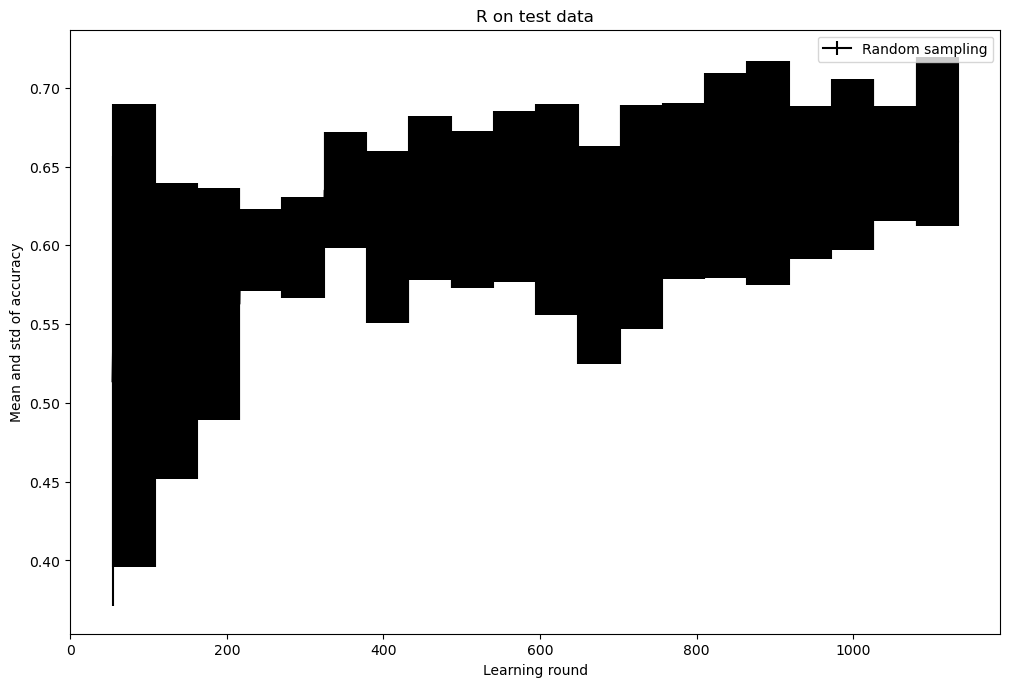

In [21]:
round_idx = np.array([i for i in range(54, 54 + 54 * 20 + 1)])
plt.figure(figsize=(12, 8), dpi=100)

# plt.errorbar(round_idx, uncertainty_unob_mean, uncertainty_unob_std, linestyle='-', marker= None,color = 'red', label = 'Uncertainty sampling')
# plt.errorbar(round_idx, diversity_unob_mean, diversity_unob_std, linestyle='-', marker=None,color = 'orange', label = 'Diversity sampling')
# plt.errorbar(round_idx, meta_unob_mean, meta_unob_std, linestyle='-', marker=None,color = 'blue', label = 'Meta learning')
# plt.errorbar(round_idx, myopic_unob_mean, myopic_unob_std, linestyle='-', marker=None,color = 'purple', label = 'Myopic sampling, batch size = 1')
plt.errorbar(round_idx, random_ubob_mean, random_unob_std, linestyle='-', marker=None,color = 'black', label = 'Random sampling')
plt.title('R on test data')
plt.xlabel('Learning round')
plt.ylabel('Mean and std of accuracy')
plt.legend()
plt.show()

# Part 2

# Cost-based Active Learning

In [18]:
data2 = pd.read_csv('classification2.csv')

In [19]:
data2.head()

,x1,x2,y,cost,Unnamed: 4
0,0.730371,0.151333,0,2.828427,2.828427
1,0.800499,0.111498,2,2.828427,5.656854
2,0.699113,0.417090,1,2.828427,8.485281
3,0.776930,0.190549,2,2.828427,11.313709
4,0.926691,0.323239,2,2.828427,14.142136


In [20]:
data2 = data2.drop(columns = ['Unnamed: 4'])
data2.head()

,x1,x2,y,cost
0,0.730371,0.151333,0,2.828427
1,0.800499,0.111498,2,2.828427
2,0.699113,0.417090,1,2.828427
3,0.776930,0.190549,2,2.828427
4,0.926691,0.323239,2,2.828427


In [21]:
data2 = data2.values

In [22]:
print(data2.shape)

(200, 4)


In [23]:
def normalize(arr):
    min_value = np.min(arr)
    max_value = np.max(arr)
    arr = (arr - min_value)/(max_value - min_value)
    return arr

In [24]:
def choose_by_utility(model, ob_data, unob_data):
    values = entropy(RF.predict_proba(unob_data[:,0:2]), axis = 1)
    cost = unob_data[:, 3]
    values_norm = normalize(values)
    cost_norm = normalize(cost)
    utility = values_norm - cost_norm
    idx = np.argmax(utility)
    return idx

In [25]:
def proactive_learning(seed_pool, data, simulation_round, model, criterion, init_num, output_ob = False):
    n_attri = data.shape[1]
    ten_sim = []
    expenditure_all = []
    all_ob_data = []
    for s in range(simulation_round):
        unob_accuracy = []
        expenditure_s = []
        ob_data, unob_data = initial_sample(s, seed_pool, data, init_num)
        init_cost = sum(ob_data[:, 3])
        curr_budge = 500 - init_cost
        learning_round = 0
        if curr_budge > 0:
            while True: 
                if learning_round >= 1:
                    idx_unob = criterion(model, ob_data, unob_data)
                    curr_budge -= unob_data[idx_unob, 3]
                    if curr_budge <= 0:
                        all_ob_data.append(ob_data)
                        break
                    ob_data = np.append(ob_data, unob_data[idx_unob].reshape(1,-1),axis = 0)
                    unob_data = np.delete(unob_data, (idx_unob), axis = 0)
                model.fit(ob_data[:,0:2],ob_data[:,2])
                acc = RF.score(unob_data[:,0:2], unob_data[:,2])
                expenditure = 500 - curr_budge
                unob_accuracy.append(acc)
                expenditure_s.append(expenditure.item())
                learning_round += 1
        ten_sim.append(unob_accuracy) 
        expenditure_all.append(expenditure_s)
        print(f'Finish simulation round {(s+1)}!')
    if output_ob == False:
        return ten_sim, expenditure_all
    else:
        return ten_sim, expenditure_all, all_ob_data

In [26]:
utility_unob, utility_exp = proactive_learning(seed_pool, data2, simulation_round, RF, choose_by_utility, 5)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!
Finish simulation round 4!
Finish simulation round 5!
Finish simulation round 6!
Finish simulation round 7!
Finish simulation round 8!
Finish simulation round 9!
Finish simulation round 10!


# Choose by the Cheapest

In [27]:
def choose_by_cheapest(model, ob_data, unob_data):
    cost = unob_data[:, 3]
    idx = np.argmin(cost)
    return idx

In [28]:
cost_unob, cost_exp = proactive_learning(seed_pool, data2, simulation_round, RF, choose_by_cheapest, 5)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!
Finish simulation round 4!
Finish simulation round 5!
Finish simulation round 6!
Finish simulation round 7!
Finish simulation round 8!
Finish simulation round 9!
Finish simulation round 10!


# Random Pro-active Learning

In [29]:
def choose_randomly(model, ob_data, unob_data):
    return np.random.choice(range(unob_data.shape[0]), 1)

In [30]:
costramdom_unob, costramdom_exp = proactive_learning(seed_pool, data2, simulation_round, RF, choose_randomly, 5)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!
Finish simulation round 4!
Finish simulation round 5!
Finish simulation round 6!
Finish simulation round 7!
Finish simulation round 8!
Finish simulation round 9!
Finish simulation round 10!


# Error of Unobserved Data by Expenditure

In [31]:
def get_acc_by_expenditrue_matrix(acc, expenditure):
    expansion = np.zeros((simulation_round, 50+1))
    for i in range(simulation_round):
        previous = 0
        for j in range(len(expenditure[i])):
            populate_to_this = int(expenditure[i][j]//10)
            if previous == 0:
                expansion[i, previous:populate_to_this] = 0
            else:
                expansion[i, previous:populate_to_this] = acc[i][j-1]
            previous = populate_to_this
        last = int(expenditure[i][-1]//10)
        expansion[i, last:] = acc[i][j]  
    return expansion

In [32]:
utility_acc_by_exp = get_acc_by_expenditrue_matrix(utility_unob, utility_exp)
cost_acc_by_exp = get_acc_by_expenditrue_matrix(cost_unob, cost_exp)
costramdom_acc_by_exp = get_acc_by_expenditrue_matrix(costramdom_unob, costramdom_exp)

In [33]:
utility_acc_by_exp_mean = np.mean(utility_acc_by_exp, axis = 0)
utility_acc_by_exp_std = np.std(utility_acc_by_exp, axis = 0)
cost_acc_by_exp_mean = np.mean(cost_acc_by_exp, axis = 0)
cost_acc_by_exp_std = np.std(cost_acc_by_exp, axis = 0)
costramdom_acc_by_exp_mean = np.mean(costramdom_acc_by_exp, axis = 0)
costramdom_acc_by_exp_std = np.std(costramdom_acc_by_exp, axis = 0)

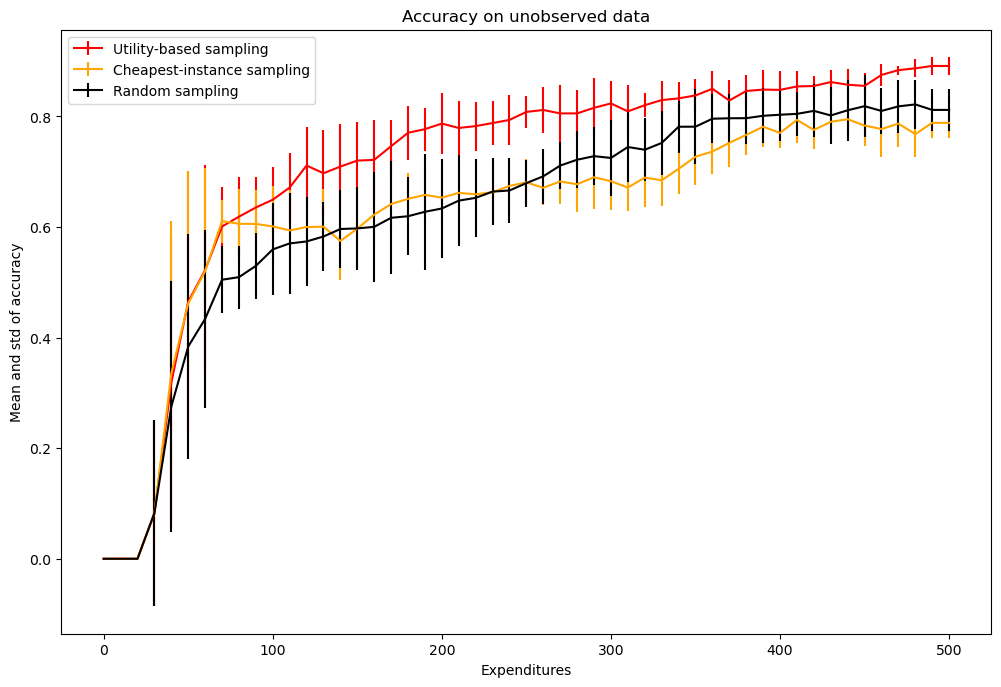

In [34]:
round_idx = np.array([i for i in range(0, 510, 10)])
plt.figure(figsize=(12, 8), dpi=100)

plt.errorbar(round_idx, utility_acc_by_exp_mean, utility_acc_by_exp_std, linestyle='-', marker= None,color = 'red', label = 'Utility-based sampling')
plt.errorbar(round_idx, cost_acc_by_exp_mean, cost_acc_by_exp_std, linestyle='-', marker=None,color = 'orange', label = 'Cheapest-instance sampling')
plt.errorbar(round_idx, costramdom_acc_by_exp_mean, costramdom_acc_by_exp_std, linestyle='-', marker=None,color = 'black', label = 'Random sampling')
plt.title('Accuracy on unobserved data')
plt.xlabel('Expenditures')
plt.ylabel('Mean and std of accuracy')
plt.legend()
plt.show()

# Part 3

In [61]:
# When Cost-sensitive sampling is worse than random sampling

In [35]:
data3 = pd.read_csv('classification2.csv')
data3.head()

,x1,x2,y,cost,Unnamed: 4
0,0.730371,0.151333,0,2.828427,2.828427
1,0.800499,0.111498,2,2.828427,5.656854
2,0.699113,0.417090,1,2.828427,8.485281
3,0.776930,0.190549,2,2.828427,11.313709
4,0.926691,0.323239,2,2.828427,14.142136


In [73]:
m_data3 = data3.drop(columns = ['Unnamed: 4'])
unclustered_data3 = m_data3.loc[:, ['x1', 'x2', 'y']]
cost_col = m_data3.loc[:, ['cost']]

In [74]:
unclustered_data3.head()

,x1,x2,y
0,0.730371,0.151333,0
1,0.800499,0.111498,2
2,0.699113,0.417090,1
3,0.776930,0.190549,2
4,0.926691,0.323239,2


In [75]:
cost_col.head()

,cost
0,2.828427
1,2.828427
2,2.828427
3,2.828427
4,2.828427


In [76]:
clustered_data3 = unclustered_data3.sort_values(by=['y'], ignore_index = True)
clustered_data3

,x1,x2,y
0,0.730371,0.151333,0
1,0.494735,0.547294,0
2,0.480415,0.508714,0
3,0.442726,0.519136,0
4,0.456700,0.512188,0
...,...,...,...
195,0.771287,0.524553,2
196,0.894097,0.970624,2
197,0.956134,0.641600,2
198,0.143497,0.665590,2


In [77]:
clustered_with_cost = pd.concat([clustered_data3, cost_col], axis = 1)
clustered_with_cost.head()

,x1,x2,y,cost
0,0.730371,0.151333,0,2.828427
1,0.494735,0.547294,0,2.828427
2,0.480415,0.508714,0,2.828427
3,0.442726,0.519136,0,2.828427
4,0.456700,0.512188,0,2.828427


In [78]:
clustered_with_cost = clustered_with_cost.values

In [79]:
np.random.seed(52)
seed_pool2 = np.random.choice(10000, simulation_round)

In [50]:
utility_unob_2, utility_exp_2, output_utility = proactive_learning(seed_pool2, clustered_with_cost, simulation_round, RF, choose_by_utility, 5, output_ob = True)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!
Finish simulation round 4!
Finish simulation round 5!
Finish simulation round 6!
Finish simulation round 7!
Finish simulation round 8!
Finish simulation round 9!
Finish simulation round 10!


In [51]:
costrandom_unob_2, costrandom_exp_2, output_costrandom = proactive_learning(seed_pool2, clustered_with_cost, simulation_round, RF, choose_randomly, 5, output_ob = True)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!
Finish simulation round 4!
Finish simulation round 5!
Finish simulation round 6!
Finish simulation round 7!
Finish simulation round 8!
Finish simulation round 9!
Finish simulation round 10!


In [55]:
cost_unob_2, cost_exp_2, output_cost = proactive_learning(seed_pool2, clustered_with_cost, simulation_round, RF, choose_by_cheapest, 5, output_ob = True)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!
Finish simulation round 4!
Finish simulation round 5!
Finish simulation round 6!
Finish simulation round 7!
Finish simulation round 8!
Finish simulation round 9!
Finish simulation round 10!


In [56]:
utility_2_acc_by_exp = get_acc_by_expenditrue_matrix(utility_unob_2, utility_exp_2)
cost_2_acc_by_exp = get_acc_by_expenditrue_matrix(cost_unob_2, cost_exp_2)
costrandom_2_acc_by_exp = get_acc_by_expenditrue_matrix(costrandom_unob_2, costrandom_exp_2)
utility_2_acc_by_exp_mean = np.mean(utility_2_acc_by_exp, axis = 0)
utility_2_acc_by_exp_std = np.std(utility_2_acc_by_exp, axis = 0)
cost_2_acc_by_exp_mean = np.mean(cost_2_acc_by_exp, axis = 0)
cost_2_acc_by_exp_std = np.std(cost_2_acc_by_exp, axis = 0)
costrandom_2_acc_by_exp_mean = np.mean(costrandom_2_acc_by_exp, axis = 0)
costrandom_2_acc_by_exp_std = np.std(costrandom_2_acc_by_exp, axis = 0)

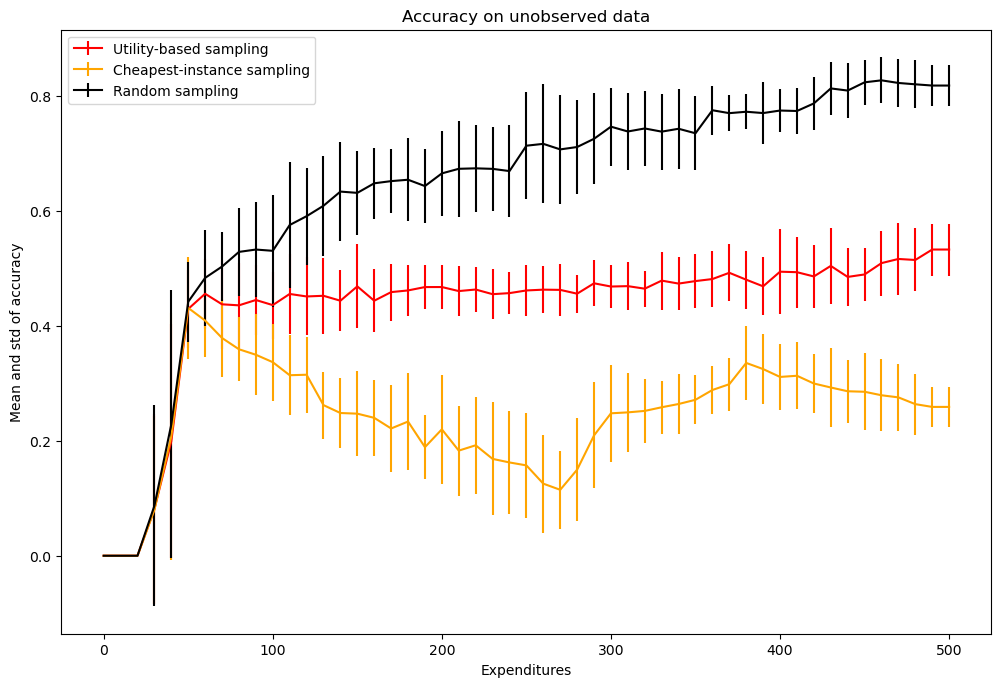

In [57]:
round_idx = np.array([i for i in range(0, 510, 10)])
plt.figure(figsize=(12, 8), dpi=100)

plt.errorbar(round_idx, utility_2_acc_by_exp_mean, utility_2_acc_by_exp_std, linestyle='-', marker= None,color = 'red', label = 'Utility-based sampling')
plt.errorbar(round_idx, cost_2_acc_by_exp_mean, cost_2_acc_by_exp_std, linestyle='-', marker=None,color = 'orange', label = 'Cheapest-instance sampling')
plt.errorbar(round_idx, costrandom_2_acc_by_exp_mean, costrandom_2_acc_by_exp_std, linestyle='-', marker=None,color = 'black', label = 'Random sampling')
plt.title('Accuracy on unobserved data')
plt.xlabel('Expenditures')
plt.ylabel('Mean and std of accuracy')
plt.legend()
plt.show()

In [60]:
#When Cost-sensitive sampling is better than random sampling

In [70]:
data4 = data3.drop(columns = ['cost', 'Unnamed: 4'])

In [71]:
data4 = data4.values

In [72]:
_, useful_points = aggresive_unob(seed_pool2, data4, simulation_round, 100, RF, shoose_by_uncertainty, 5, 1, output_ob = True)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!
Finish simulation round 4!
Finish simulation round 5!
Finish simulation round 6!
Finish simulation round 7!
Finish simulation round 8!
Finish simulation round 9!
Finish simulation round 10!


In [80]:
freq = useful_points[0]
for r in range(1, len(useful_points)):
    freq = np.concatenate((freq, useful_points[r]), axis = 0)  
bb=list([tuple(t) for t in freq])
aa1= dict((aaa, bb.count(aaa)) for aaa in bb)
key=aa1.keys()
value=aa1.values()
alist=list(zip(key,value))
sorted_freq = sorted(alist, key=lambda x: x[1], reverse = True)
useful_points_2 = np.array([list(i[0]) for i in sorted_freq])[0:50, :]

In [81]:
def find_index(arr, row):
    return np.where(np.all(arr==row,axis=1))[0].item()

In [82]:
useful_idx = []
for each in useful_points_2:
    idx = find_index(data4, each)
    useful_idx.append(idx)

In [83]:
mask = np.full(len(data4), True)
mask[useful_idx] = False
useless_points_2 = data4[mask]
useless_points_2.shape

(150, 3)

In [84]:
sorted1_data3 = np.concatenate((useful_points_2, useless_points_2), axis = 0)
cost_col = data3.loc[:,'cost'].values.reshape(-1,1)
sorted1_data3 = np.concatenate((sorted1_data3, cost_col), axis = 1)

In [85]:
utility_unob_2, utility_exp_2, output_utility = proactive_learning(seed_pool2, sorted1_data3, simulation_round, RF, choose_by_utility, 5, output_ob = True)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!
Finish simulation round 4!
Finish simulation round 5!
Finish simulation round 6!
Finish simulation round 7!
Finish simulation round 8!
Finish simulation round 9!
Finish simulation round 10!


In [86]:
cost_unob_2, cost_exp_2, output_cost = proactive_learning(seed_pool2, sorted1_data3, simulation_round, RF, choose_by_cheapest, 5, output_ob = True)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!
Finish simulation round 4!
Finish simulation round 5!
Finish simulation round 6!
Finish simulation round 7!
Finish simulation round 8!
Finish simulation round 9!
Finish simulation round 10!


In [87]:
costrandom_unob_2, costrandom_exp_2, output_costrandom = proactive_learning(seed_pool2, sorted1_data3, simulation_round, RF, choose_randomly, 5, output_ob = True)

Finish simulation round 1!
Finish simulation round 2!
Finish simulation round 3!
Finish simulation round 4!
Finish simulation round 5!
Finish simulation round 6!
Finish simulation round 7!
Finish simulation round 8!
Finish simulation round 9!
Finish simulation round 10!


In [88]:
utility_2_acc_by_exp = get_acc_by_expenditrue_matrix(utility_unob_2, utility_exp_2)
cost_2_acc_by_exp = get_acc_by_expenditrue_matrix(cost_unob_2, cost_exp_2)
costrandom_2_acc_by_exp = get_acc_by_expenditrue_matrix(costrandom_unob_2, costrandom_exp_2)
utility_2_acc_by_exp_mean = np.mean(utility_2_acc_by_exp, axis = 0)
utility_2_acc_by_exp_std = np.std(utility_2_acc_by_exp, axis = 0)
cost_2_acc_by_exp_mean = np.mean(cost_2_acc_by_exp, axis = 0)
cost_2_acc_by_exp_std = np.std(cost_2_acc_by_exp, axis = 0)
costrandom_2_acc_by_exp_mean = np.mean(costrandom_2_acc_by_exp, axis = 0)
costrandom_2_acc_by_exp_std = np.std(costrandom_2_acc_by_exp, axis = 0)

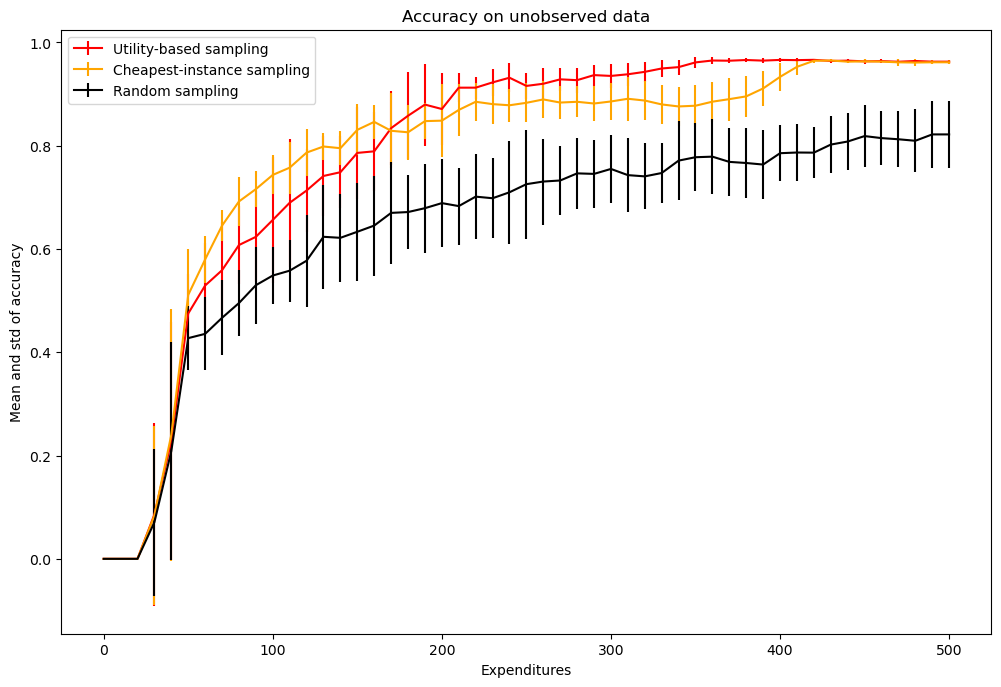

In [89]:
round_idx = np.array([i for i in range(0, 510, 10)])
plt.figure(figsize=(12, 8), dpi=100)

plt.errorbar(round_idx, utility_2_acc_by_exp_mean, utility_2_acc_by_exp_std, linestyle='-', marker= None,color = 'red', label = 'Utility-based sampling')
plt.errorbar(round_idx, cost_2_acc_by_exp_mean, cost_2_acc_by_exp_std, linestyle='-', marker=None,color = 'orange', label = 'Cheapest-instance sampling')
plt.errorbar(round_idx, costrandom_2_acc_by_exp_mean, costrandom_2_acc_by_exp_std, linestyle='-', marker=None,color = 'black', label = 'Random sampling')
plt.title('Accuracy on unobserved data')
plt.xlabel('Expenditures')
plt.ylabel('Mean and std of accuracy')
plt.legend()
plt.show()